In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import os
import sys
sys.path.append('../')
from seislab.src import segyrw
from seislab.src import plot_seismic
from seislab.src import plot_maps
# from seislab.src import keras_models as km
from seislab.src import fbpick as ut
from sklearn.linear_model import LinearRegression
import seaborn as sns

## Считывание данных

In [2]:
filename = 'w1_cdp.sgy'

In [3]:
def Ampl_rms(head,data,t1,t2):
    head['Ampl_RMS'] = 0.0
    for z in head['CDP'].unique():
        ind = head[head['CDP'] == z].index
        T0 = head.iloc[ind]['T0'].reset_index(drop=True)
        int1 = T0*1e-3 - t1
        int2 = T0*1e-3 + t2
        data_temp = data[int(int1[0]/dt):int(int2[0]/dt),ind]
        for i in range(len(data_temp[0,:])):
            head['Ampl_RMS'][ind[i]] = np.sqrt(sum(data_temp[:,i]*data_temp[:,i])/len(data_temp[:,i]))
    return head

def read_segy_head_cdp_off(filename):
    data = segyrw.read_segy_file_obspy(filename)
    data = data.T
    head = segyrw.read_header_segyio_full(filename)
    head = segyrw.read_header_segyio_full(filename)
    dt = segyrw.read_bin_header(filename)
    dt = dt['SampleIntervalReel']*1e-6
    head = head.loc[:,['ReceiverGroupElevation','SourceSurfaceElevation','CDP',
                   'SRCX','SRCY','GRPX','GRPY','CDP_X','CDP_Y','OFFSET']]
    head = head.rename(columns = {'ReceiverGroupElevation':'GRPZ','SourceSurfaceElevation':'SRCZ',
                              'CDP_X':'CDPX','CDP_Y':'CDPY'})
    head = head.sort_values(['CDP', 'OFFSET'])
    data = data[:,head.index]
    head = head.reset_index(drop=True)
    
    return head, data, dt

def metrics_theor_real_data(head, ampl, offsets, interval1, interval2, threshold):   
    head_tmp = head.copy()
    head_tmp = head_tmp[interval1:interval2]
    real = head_tmp['Ampl_RMS'].values[interval1:interval2]/max(head_tmp['Ampl_RMS'].values[interval1:interval2])
    theor = ampl[interval1:interval2]/max(ampl[interval1:interval2])

    diff = abs(theor-real)
    head_tmp['diff_%'] = diff*100
    disp = np.std(diff)*np.std(diff)
    kmean = np.mean(diff)
   
    head_tmp['colors'] = 'g'
    head_tmp['colors'][head_tmp[(abs( head_tmp['diff_%']) >= threshold)].index] = 'r'
   
    
    sns.set()
    fig = plt.figure(figsize = (10,5))
    plt.plot(offsets[interval1:interval2],real,'b.', label = 'Ампл. по сейсм.')
    plt.plot(offsets[interval1:interval2],theor,'g.',label = 'Теорет.распр.')
    plt.xlabel('Offset, m')
    plt.ylabel('norm(max_Ampl)')
    plt.legend()
    plt.title('mean = '+str(np.round(kmean*10000)/10000)+', disp = '+str(np.round(disp*10000)/10000))
    return head_tmp

def plot_metrics(head, offsets, threshold):
    sns.set()
    fig = plt.figure(figsize = (10,5))
    plt.scatter(offsets,head['diff_%'].values,c = head['colors'],s = 10)
    plt.ylim(-100,100)
    plt.title('Разница между теоретическим распр. и реальными данными, пороговое значение = '+str(threshold)+'%')
    plt.xlabel('Offset, m')
    plt.ylabel('diff Ampl %')
    return 

In [4]:
wellname = 'Z-Zim-1jgw.las'#directory+'Z-Zim-1jgw.las'
f = open(wellname, 'r', encoding='utf-8', errors='ignore')
o = 0
Depth = []
TVD = []
TVDSS = []
DELTAX = []
DELTAY = []
DTS = []
DT = []
RHOB = []

for line in f.readlines():
    if o >= 43:
        Depth.append(np.float(line.split()[0]))
        TVD.append(np.float(line.split()[1]))
        TVDSS.append(np.float(line.split()[2]))
        DELTAX.append(np.float(line.split()[3]))
        DELTAY.append(np.float(line.split()[4]))
        DTS.append(np.float(line.split()[5]))
        DT.append(np.float(line.split()[6]))
        RHOB.append(np.float(line.split()[7]))       
    o += 1
    
well_priory = pd.DataFrame({'Depth':Depth,'TVD':TVD,'TVDSS':TVDSS,'DELTAX':DELTAX,
                     'DELTAY':DELTAY,'DTS':DTS,'DT':DT,'RHOB':RHOB})

ind = well_priory[(well_priory['RHOB'] != -999.25) & (well_priory['DTS'] != -999.25) & (well_priory['DT'] != -999.25)].index
well_priory = well_priory.iloc[ind].reset_index(drop = True)
well_priory['DTS'] = 1/well_priory['DTS'].values
well_priory['DT'] = 1/well_priory['DT'].values
well_priory = well_priory.rename(columns = {'DTS':'Vs','DT':'Vp'})
well_X = 500001; well_Y = 6637623.6

In [5]:
wellname = 'Z-Zim-1_TIME.las'#directory+'Z-Zim-1_TIME.las'
f = open(wellname, 'r', encoding='utf-8', errors='ignore')
o = 0
Depth = []
TVDSS = []
Time = []


for line in f.readlines():
    if o >= 43:
        Depth.append(np.float(line.split()[0]))
        TVDSS.append(np.float(line.split()[1]))
        Time.append(np.float(line.split()[2]))       
    o += 1
well_T = pd.DataFrame({'Depth_T':Depth,'TVDSS_T':TVDSS,'Time':Time})
well_T['Time'] = well_T['Time']*1000

In [6]:
filename1 = filename#directory+filename
head1,data1,dt = read_segy_head_cdp_off(filename1)
head1 = head1.drop(columns = ['GRPZ','SRCZ','SRCX','SRCY','GRPX','GRPY'])

/home/jarvis/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [7]:
head1['well_X'] = well_X; head1['well_Y'] = well_Y
head1['OFF'] = np.sqrt(((head1[['CDPX', 'CDPY']].values - head1[['well_X', 'well_Y']].values) ** 2).sum(axis=1))

In [8]:
head1

,CDP,CDPX,CDPY,OFFSET,well_X,well_Y,OFF
0,NaN,499950,6637576,NaN,500001,6637623.6,69.762167
1,NaN,499950,6637576,NaN,500001,6637623.6,69.762167
2,NaN,499950,6637576,NaN,500001,6637623.6,69.762167
3,NaN,499950,6637576,NaN,500001,6637623.6,69.762167
4,NaN,499950,6637576,NaN,500001,6637623.6,69.762167
...,...,...,...,...,...,...,...
3520,NaN,500050,6637676,NaN,500001,6637623.6,71.740923
3521,NaN,500050,6637676,NaN,500001,6637623.6,71.740923
3522,NaN,500050,6637676,NaN,500001,6637623.6,71.740923
3523,NaN,500050,6637676,NaN,500001,6637623.6,71.740923


In [9]:
head1['OFF'].min()

2.600000000343873

In [10]:
indexies = head1[head1['OFF']==head1['OFF'].min()].index

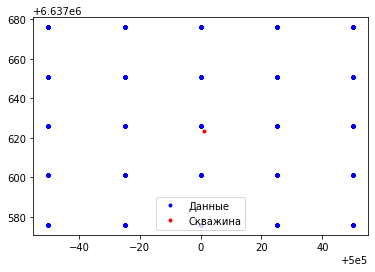

In [13]:
plt.plot(head1['CDPX'],head1['CDPY'],'b.',label = 'Данные')
plt.plot(well_X,well_Y,'r.',label = 'Скважина')
plt.legend()

## Визуализация

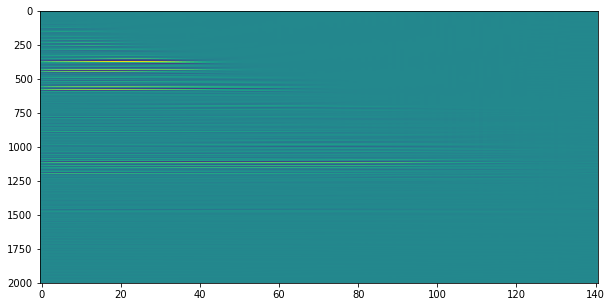

In [14]:
plt.figure(figsize=(10,5))
plt.imshow(data1[:,indexies],aspect='auto')

## Выбор интервала анализа

In [15]:
int1 = 1060; int2 = 1150;

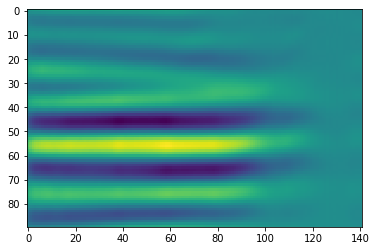

In [16]:
plt.imshow(data1[int1:int2,indexies],aspect='auto')

## Совмещение скважинных данных с анализируемым интервалом

In [17]:
well_TH = well_T[(well_T['Time'] >= int1*dt*1000) & (well_T['Time'] <= int2*dt*1000)]
well_TH = well_TH.rename(columns = {'Depth_T':'Depth'})

In [18]:
well = pd.merge(well_priory, well_TH, on = ['Depth'])

In [19]:
well

,Depth,TVD,TVDSS,DELTAX,DELTAY,Vs,Vp,RHOB,TVDSS_T,Time
0,2569.9212,2569.8141,2524.3841,7.978030,7.589370,1734.568279,3720.966508,2427.9508,2524.3841,2120.0585
1,2570.0736,2569.9665,2524.5365,7.981619,7.590515,1748.297931,3745.532984,2393.6660,2524.5365,2120.1465
2,2570.2260,2570.1188,2524.6888,7.984972,7.591582,1779.964967,3775.554320,2376.3226,2524.6888,2120.2346
3,2570.3784,2570.2712,2524.8412,7.988325,7.592649,1836.111042,3798.315812,2362.4349,2524.8412,2120.3226
4,2570.5308,2570.4235,2524.9935,7.991678,7.593716,1859.790367,3779.922481,2350.2689,2524.9935,2120.4093
...,...,...,...,...,...,...,...,...,...,...
1927,2863.5960,2863.1564,2817.7264,19.439700,8.570000,1937.866759,3672.187629,2538.1886,2817.7264,2299.6250
1928,2863.7484,2863.3084,2817.8784,19.451130,8.570000,1958.042287,3702.945011,2450.5504,2817.8784,2299.7206
1929,2863.9008,2863.4604,2818.0304,19.462560,8.570000,1999.678732,3766.417484,2304.1423,2818.0304,2299.8117
1930,2864.0532,2863.6123,2818.1823,19.473990,8.570000,2061.614525,3860.558481,2218.8003,2818.1823,2299.9027


## Сглаживание скважинных данных и визуализация

In [20]:
import scipy.signal as scp
polynom = 2
window_len = 501

Text(0.5, 1.0, 'pho')

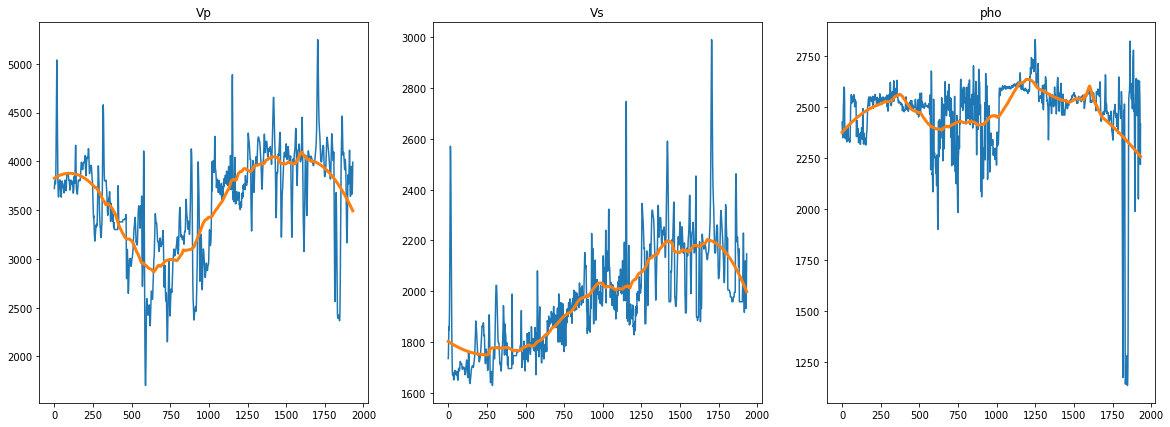

In [21]:
fig,axs = plt.subplots(1,3,figsize=(20,7))
axs[0].plot(well['Vp'].values)
axs[0].plot(scp.savgol_filter(well['Vp'].values,window_len,polynom),linewidth = 3)
axs[0].set_title('Vp')

axs[1].plot(well['Vs'].values)
axs[1].plot(scp.savgol_filter(well['Vs'].values,window_len,polynom),linewidth = 3)
axs[1].set_title('Vs')

axs[2].plot(well['RHOB'].values)
axs[2].plot(scp.savgol_filter(well['RHOB'].values,window_len,polynom),linewidth = 3)
axs[2].set_title('pho')

In [22]:
well['Vp_smooth'] = scp.savgol_filter(well['Vp'].values,window_len,polynom)
well['Vs_smooth'] = scp.savgol_filter(well['Vs'].values,window_len,polynom)
well['RHOB_smooth'] = scp.savgol_filter(well['RHOB'].values,window_len,polynom)

In [24]:
well

,Depth,TVD,TVDSS,DELTAX,DELTAY,Vs,Vp,RHOB,TVDSS_T,Time,Vp_smooth,Vs_smooth,RHOB_smooth
0,2569.9212,2569.8141,2524.3841,7.978030,7.589370,1734.568279,3720.966508,2427.9508,2524.3841,2120.0585,3826.701978,1802.062546,2377.344425
1,2570.0736,2569.9665,2524.5365,7.981619,7.590515,1748.297931,3745.532984,2393.6660,2524.5365,2120.1465,3827.731580,1801.655679,2378.219505
2,2570.2260,2570.1188,2524.6888,7.984972,7.591582,1779.964967,3775.554320,2376.3226,2524.6888,2120.2346,3828.750595,1801.250373,2379.092043
3,2570.3784,2570.2712,2524.8412,7.988325,7.592649,1836.111042,3798.315812,2362.4349,2524.8412,2120.3226,3829.759022,1800.846628,2379.962041
4,2570.5308,2570.4235,2524.9935,7.991678,7.593716,1859.790367,3779.922481,2350.2689,2524.9935,2120.4093,3830.756861,1800.444446,2380.829499
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927,2863.5960,2863.1564,2817.7264,19.439700,8.570000,1937.866759,3672.187629,2538.1886,2817.7264,2299.6250,3506.507124,2004.093354,2262.007618
1928,2863.7484,2863.3084,2817.8784,19.451130,8.570000,1958.042287,3702.945011,2450.5504,2817.8784,2299.7206,3503.150197,2002.584635,2261.093177
1929,2863.9008,2863.4604,2818.0304,19.462560,8.570000,1999.678732,3766.417484,2304.1423,2818.0304,2299.8117,3499.782289,2001.070220,2260.177617
1930,2864.0532,2863.6123,2818.1823,19.473990,8.570000,2061.614525,3860.558481,2218.8003,2818.1823,2299.9027,3496.403398,1999.550112,2259.260938


## Расчет теоретического распределения амплитуд

In [25]:
## получение коэффициентов отражения
h = np.arange(100,5150,35)#head1['OFFSET'].unique()
Vp = well['Vp'].values
Vs = well['Vs'].values
pho = well['RHOB'].values
R = []
offset = []
th = []
Z = []
Times = []
theta = np.arctan(h/well['Depth'].values[0])
for i in range(len(well)-1):
    dVp = Vp[i+1]-Vp[i]
    mVp = (Vp[i+1]+Vp[i])/2
    dVs = Vs[i+1]-Vs[i]
    mVs = (Vs[i+1]+Vs[i])/2
    dpho = pho[i+1]-pho[i]
    mpho = (pho[i+1]+pho[i])/2
    
    A = 1/2*(dVp/mVp+dpho/mpho)
    B = 1/2*dVp/mVp-4*((mVs*mVs)/(mVp*mVp))*(dVs/mVs)-2*((mVs*mVs)/(mVp*mVp))*dpho/mpho
    C = 1/2*(dVp/mVp)
    
    for j in range(len(theta)):
        M = A + B*np.sin(theta[j])*np.sin(theta[j]) #+ C*(np.tan(theta[j])*np.tan(theta[j])-np.sin(theta[j])*np.sin(theta[j]))
        R.append(M),0
        offset.append(h[j])
        Times.append(well['Time'].values[i])
        th.append(theta[j])
        Z.append(well['Depth'].values[i])

df_R = pd.DataFrame({'Depth':Z,'R':R,'offset':offset,'theta':th,'time':Times})

In [26]:
df_R

,Depth,R,offset,theta,time
0,2569.9212,-0.003816,100,0.038892,2120.0585
1,2569.9212,-0.003813,135,0.052483,2120.0585
2,2569.9212,-0.003809,170,0.066054,2120.0585
3,2569.9212,-0.003804,205,0.079600,2120.0585
4,2569.9212,-0.003798,240,0.093118,2120.0585
...,...,...,...,...,...
279990,2864.0532,-0.003541,5000,1.096024,2299.9027
279991,2864.0532,-0.003724,5035,1.098854,2299.9027
279992,2864.0532,-0.003905,5070,1.101654,2299.9027
279993,2864.0532,-0.004084,5105,1.104422,2299.9027


## амплитуды по реальным данным

In [27]:
head1['Ampl_RMS'] = 0.0
for z in range(len(indexies)):
    data_temp = data1[int1:int2,indexies[z]]
    head1['Ampl_RMS'][z] = np.max(data_temp)#np.sqrt(sum(data_temp*data_temp)/len(data_temp))

/home/jarvis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

x = np.arange(0,len(head1['Ampl_RMS'].values[0:141]))
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x.reshape(-1, 1))


model = LinearRegression()
model.fit(x_poly, head1['Ampl_RMS'].values[0:141]/max(head1['Ampl_RMS'].values[0:141]))
y_poly_pred = model.predict(x_poly)


In [29]:
df_R = df_R.sort_values(by=['theta','Depth'])  

In [30]:
data_synt = []
for i in range(len(df_R['offset'].unique())):
    data_synt.append(df_R.loc[df_R['offset']==df_R['offset'].unique()[i]]['R'])
data_synt_ar = np.asarray(data_synt)

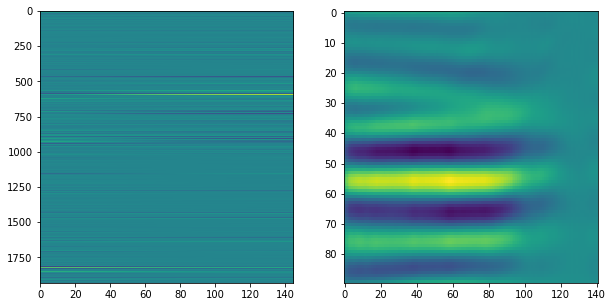

In [31]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(data_synt_ar.T,aspect = 'auto')
axs[1].imshow(data1[int1:int2,indexies],aspect='auto')

In [32]:
time = df_R.loc[df_R['offset']==df_R['offset'].unique()[0]]['time']

In [39]:
## подгрузка импульса

In [33]:
T=np.arange(-0.05,0.051,0.002)
T_int=np.arange(-0.05,0.0501,0.0001)
Sig=[]

f= open('ss.txt')
for line in f.readlines():
    Sig.append(np.float(line.split()[0]))


Sig=np.interp(T_int,T,Sig)

In [34]:
trace_synt = []
for i in range(len(data_synt_ar[:,0])):
    #Sig2=np.interp(T_int,time,data_synt_ar[i,:])
    trace_synt.append(np.convolve(Sig,data_synt_ar[i,:],mode='same'))
trace_synt_ar = np.asarray(trace_synt)

Text(0, 0.5, 'T,s')

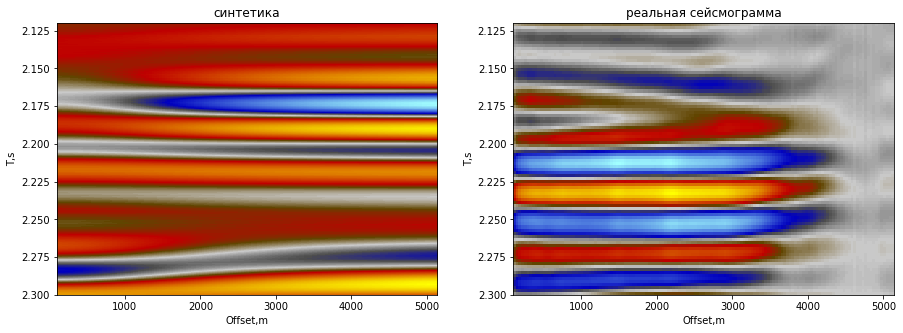

In [35]:
from seiscm import seismic
fig,axs = plt.subplots(1,2, figsize = (15,5))
axs[0].imshow(trace_synt_ar.T,aspect='auto',cmap =seismic(),extent = [df_R['offset'].min(),df_R['offset'].max(),int2*dt,int1*dt])
axs[0].set_title('синтетика')
axs[0].set_xlabel('Offset,m')
axs[0].set_ylabel('T,s')
axs[1].imshow(data1[int1:int2,indexies],aspect='auto',cmap =seismic(),extent = [df_R['offset'].min(),df_R['offset'].max(),int2*dt,int1*dt])
axs[1].set_title('реальная сейсмограмма')
axs[1].set_xlabel('Offset,m')
axs[1].set_ylabel('T,s')

## амплитуды по теории

In [36]:
ampl = []
for z in range(trace_synt_ar.shape[0]):
    ampl.append(np.max(trace_synt_ar[z,:]))#np.sqrt(sum(trace_synt_ar[z,:]*trace_synt_ar[z,:])/trace_synt_ar.shape[1]))

/home/jarvis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


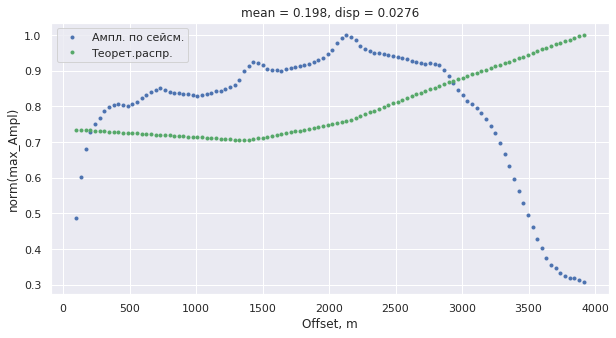

In [37]:
interval1 = 0
interval2 = 110
threshold = 20
head_new = metrics_theor_real_data(head1, ampl, df_R['offset'].unique(), interval1, interval2, threshold)

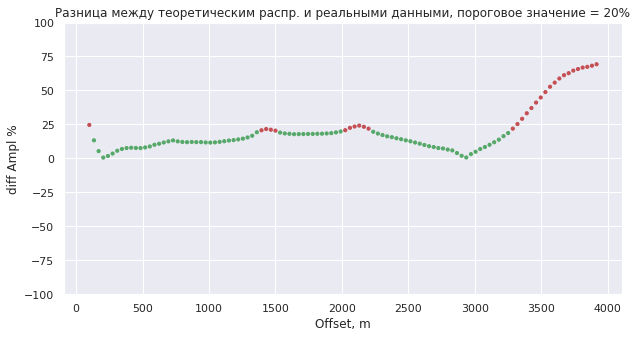

In [38]:
plot_metrics(head_new, df_R['offset'].unique()[interval1:interval2], threshold)